##### 1. INSTALL AND IMPORT DEPENDENCIES

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time,json,uuid
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Layer,Conv2D,MaxPooling2D,Input


##### 2 CREATE FOLDER STRUCTURE

In [2]:
# Setup paths

''' we will be using the siamese neural network which performs one shot 
recogonition, hence we will need the input images to be compared to some 
other images. We will represent the input images lookalike as positive and
it opposite will be negative and input image will be name anchor '''


PATHS = {
    'data': Path('data'),
    'positive_path': Path('data','positive'),
    'negative_path': Path('data','negative'),
    'anchor_path': Path('data','anchor'),
}

# create directories
for key in PATHS.keys():
    PATHS[key].mkdir(parents=True,exist_ok=True)

##### 3. UNTAR LABELLED FACES IN THE WILD DATASET

In [5]:
!tar -xf lfw.tgz

In [20]:
def traverse_directory(folder_path):
    for item in folder_path.iterdir():
        if item.is_file():
            shutil.copy(item,PATHS['negative_path'])
        if item.is_dir():
            traverse_directory(item)

traverse_directory(Path('lfw'))

##### 4. COLLECT POSITIVES AND ANCHORS

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    if not ret:
        break

    frame = frame[120:120+250,200:200+250,:]

    if cv2.waitKey(1) & 0xFF == ord('a'):
        image_filepath = f"{Path(PATHS['anchor_path'],str(uuid.uuid1()) + '.jpg')}"
        cv2.imwrite(image_filepath,frame)

    if cv2.waitKey(1) & 0xFF == ord('p'):
        image_filepath = f"{Path(PATHS['positive_path'],str(uuid.uuid1()) + '.jpg')}"
        cv2.imwrite(image_filepath,frame)


    cv2.imshow('Image Collection',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

##### 5. PROPROCESS IMAGES( BY CREATING POSITIVE AND NEGATIVE SAMPLES)

In [3]:
def create_dataset(pattern):
    datasets = tf.data.Dataset.list_files(pattern,shuffle=False).take(300)
    datasets = datasets.map(read_file)
    return datasets

def read_file(x):
    img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img,(100,100))
    img = img / 255
    return img

def labelled_dataset(data1,data2,label):
    if label == 0:
        lab_dataset = tf.data.Dataset.zip((data1,data2,tf.data.Dataset.from_tensor_slices(tf.zeros(len(data1)))))
    if label == 1:
        lab_dataset = tf.data.Dataset.zip((data1,data2,tf.data.Dataset.from_tensor_slices(tf.ones(len(data1)))))
    return lab_dataset

anchor = create_dataset(str(Path(PATHS['anchor_path'],'*.jpg')))
positive = create_dataset(str(Path(PATHS['positive_path'],'*.jpg')))
negative = create_dataset(str(Path(PATHS['negative_path'],'*.jpg')))

In [20]:
positive_label = labelled_dataset(anchor,positive,1)
negative_label = labelled_dataset(anchor,negative,0)

In [21]:
all_dataset = positive_label.concatenate(negative_label)
all_dataset = all_dataset.cache()
all_dataset = all_dataset.shuffle(buffer_size=1024)

In [81]:
a = all_dataset.as_numpy_iterator()

1.0


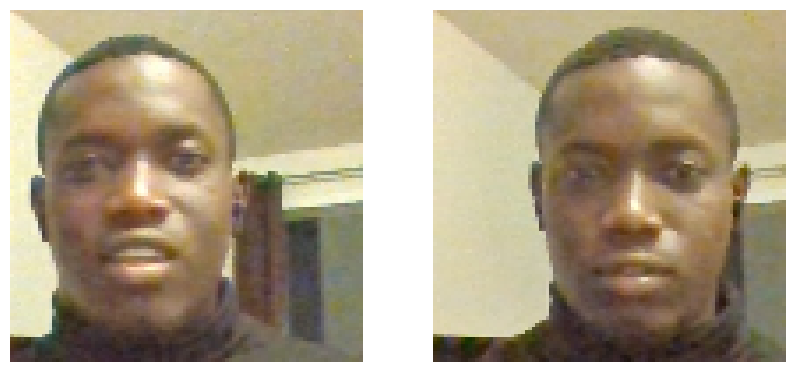

In [138]:
def plot_dataset_image(image):
    fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i in range(2):
        axes[i].imshow(image[i])
        axes[i].axis('off')
    print(image[2])

plot_dataset_image(a.next())

##### 6. SPLIT TO TRAIN AND TEST PARTITION

In [99]:
length_of_dataset = len(all_dataset)
length_of_dataset

600

In [22]:
train_dataset = all_dataset.take(round(len(all_dataset) * .7))
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.prefetch(8)

test_dataset = all_dataset.skip(round(len(all_dataset) * .7))
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)


##### 6. MODEL ENGINEERING

###### 6.1 BUILD AN EMBEDDING LAYER

In [4]:
def make_embedding():
    input = Input(shape=(100,100,3),name='input layer')

    # first conv and maxpool block
    c1 = Conv2D(64,(10,10),activation='relu')(input)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

    # second conv and maxpool block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

    # third conv and maxpool block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)

    # fourth conv and maxpool block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)

    # fully connected layer
    f1 = Flatten()(c4)
    
    d1 = Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=[input],outputs=[d1],name='embedded_model')

embedded_model = make_embedding()
embedded_model.summary()

Model: "embedded_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)    

###### 6.2 build distance layer and build siamese network

In [5]:
# Create L1 distance layer
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validating_embedding):
        return tf.math.abs(input_embedding - validating_embedding)
    
def make_siamese_model():

    # anchor image shape
    input_image = Input(shape=(100,100,3),name='anchor_shape')

    # validating image shape
    validation_image = Input(shape=(100,100,3),name='validation_shape')

    L1_distance_Layer = L1Dist()
    L1_distance_Layer._name = 'distancelayer'
    distance = L1_distance_Layer(embedded_model(input_image),embedded_model(validation_image))

    # Classification layer

    dense = Dense(1,activation='sigmoid',name='predictionlayer')(distance)
    return Model(inputs=[input_image,validation_image],outputs=[dense],name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_shape (InputLayer)   [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_shape (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedded_model (Functional  (None, 4096)                 3896044   ['anchor_shape[0][0]',        
 )                                                        8          'validation_shape[0][0]']    
                                                                                     

##### 7. TRAIN MODEL

###### 7.1 Setup Loss and Optimizer

In [6]:
binary_cross_loss = tf.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

###### 7.2 Establish Checkpoints

In [7]:
checkpoint_dir = './training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,siamese_model=siamese_model)

###### 7.3 Build Train Step Function

In [17]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X,training=True)
        yhat = tf.squeeze(yhat)
        loss = binary_cross_loss(y,yhat)

    print(loss)
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss


###### 7.4 Build training loop

In [18]:
def train(data,EPOCHS):
    # Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        # loop through each batch
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            


In [161]:
EPOCHS = 50

In [24]:
train(train_dataset,20)


 Epoch 1/20
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
27/27 [==============================] - 693s 26s/step

 Epoch 2/20
27/27 [==============================] - 681s 25s/step

 Epoch 3/20
27/27 [==============================] - 680s 25s/step

 Epoch 4/20
27/27 [==============================] - 682s 25s/step

 Epoch 5/20
27/27 [==============================] - 683s 25s/step

 Epoch 6/20
27/27 [==============================] - 685s 25s/step

 Epoch 7/20
27/27 [==============================] - 681s 25s/step

 Epoch 8/20
27/27 [==============================] - 683s 25s/step

 Epoch 9/20
27/27 [==============================] - 686s 25s/step

 Epoch 10/20
27/27 [==============================] - 669s 25s/step

 Epoch 11/20
27/27 [==============================] - 672s 25s/step

 Epoch 12/20
27/27 [==============================] - 668s 25s/step

 Epoch 13/20
27/27 [==============================] - 668s 25s/step

 Epoch 14/20
27/27 [=======

In [ ]:
##### 8. Evaluate Model

In [25]:
from tensorflow.keras.metrics import Precision,Recall

In [26]:
test_input,test_val,y_true = test_dataset.as_numpy_iterator().next()

In [27]:
test_input.shape

(16, 100, 100, 3)

In [28]:
yhat = siamese_model.predict([test_input,test_val])
yhat

1/1 [==============================] - 7s 7s/step


array([[3.7335780e-16],
       [9.9984622e-01],
       [7.3231647e-16],
       [7.6975986e-12],
       [9.9998778e-01],
       [1.0000000e+00],
       [4.7631218e-08],
       [1.0000000e+00],
       [1.6227349e-07],
       [6.9456947e-11],
       [9.9999982e-01],
       [8.4579205e-11],
       [9.9999994e-01],
       [1.0000000e+00],
       [5.4706978e-14],
       [1.6130821e-09]], dtype=float32)

In [29]:
y_true

array([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [30]:
yhat = (yhat > 0.5).astype(int)
yhat

array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [31]:
m = Recall()
m.update_state(y_true,yhat)
m.result().numpy()


1.0

In [32]:
p = Precision()
p.update_state(y_true,yhat)
p.result().numpy()

1.0

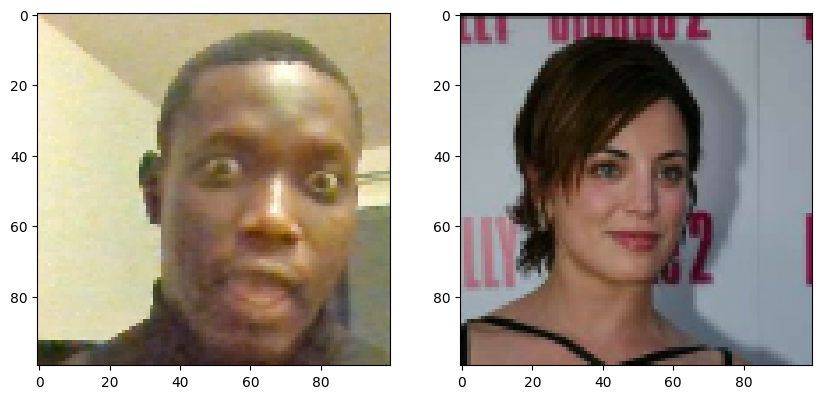

In [33]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].imshow(test_input[6])
axes[1].imshow(test_val[6])

##### 9. SAVE MODEL

In [34]:
siamese_model.save('siamesemodel.h5')

c:\Users\bkj\Documents\GitHub\projects\computer vision\cv-env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
#Reload Model
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'binary_cross_loss':binary_cross_loss,'L1Dist':L1Dist})

In [36]:
(model.predict([test_input,test_val])>0.5).astype(int)

1/1 [==============================] - 5s 5s/step


array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [209]:
y_true

array([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [206]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_shape (InputLayer)   [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_shape (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedded_model (Functional  (None, 4096)                 3896044   ['anchor_shape[0][0]',        
 )                                                        8          'validation_shape[0][0]']    
                                                                                     

##### 10. REAL TIME TEST

In [37]:
def verify(frame_path,model,detection_threshold,verification_threshold):
    results = []
    for file in os.listdir(os.path.join("application_data",'verification_image')):
        input_img = read_file(os.path.join('application_data','input_image',frame_path))
        validation_img = read_file(os.path.join('application_data','verification_image',file))

        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join("application_data",'verification_image')))
    verified = verification > verification_threshold

    return results, verified

In [38]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    if not ret:
        break
    frame = frame[120:120+250,200:200+250,:]

    cv2.imshow('real time detection',frame)

    if cv2.waitKey(1) & 0xFF == ord('v'):
        image_relpath = str(uuid.uuid1())+'.jpg'
        image_fullpath = os.path.join('application_data','input_image',image_relpath)
        cv2.imwrite(image_fullpath,frame)
        results,verified = verify(image_relpath,model=model,detection_threshold=0.5,verification_threshold=0.6)
        if verified:
            print(f"{image_relpath} has been verified")
        else:
            print(f'{image_relpath} is not verified')

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 499ms/step
5fd4e6ea-6050-11ee-b8ee-ec5c68664d70.jpg is not verified
